# VolSense Notebook 04 — Cross-Sector Signals & Market Intelligence

## 1️⃣ Notebook Overview

This notebook explores the **Signal Engine** — the final stage of the VolSense workflow that translates raw forecasts and analytics into **interpretable market-level insights**:

* Understand the architecture and logic of `signal_engine.py`.
* Generate **sector-level volatility heatmaps**.
* Quantify **cross-horizon alignment** and **volatility divergence**.
* Produce **ticker-level relative strength signals** for trader decision support.

## 2️⃣ Imports & Setup

In [2]:

from volsense_inference.signal_engine import SignalEngine
from volsense_inference.forecast_engine import Forecast

## 3️⃣ Load Forecast Data

We’ll reuse the **v509 flagship model**, which provides the richest cross-sector forecasts.

In [4]:
fcast = Forecast(model_version="v109", checkpoints_dir="models")

# Pick 70 stable tickers from v109 universe (yfinance-compatible)

TICKERS = [
    # Index / ETF
    "SPY","QQQ","DIA","IWM","GLD","SLV","TLT","HYG","EEM",
    # Tech
    "AAPL","MSFT","GOOG","AMZN","META","NVDA","AVGO","AMD","INTC","ORCL",
    "CRM","TXN","QCOM","ADI","MU","CSCO",
    # Financials
    "JPM","BAC","C","WFC","GS","MS","V","MA","AXP","SCHW",
    # Healthcare
    "JNJ","PFE","MRK","UNH","ABBV","ABT","LLY","BMY","TMO","CVS",
    # Energy / Materials
    "XOM","CVX","COP","SLB","HAL","BP","BHP","RIO","FCX",
    # Consumer Discretionary
    "TSLA","HD","MCD","NKE","SBUX","TGT","BKNG","CMG",
    # Industrials
    "CAT","BA","HON","UPS","FDX","LMT","GE",
    # Consumer Staples
    "PG","KO","PEP","COST","WMT"
]

print(f"✅ Loaded {len(TICKERS)} tickers for this run.")
preds = fcast.run(TICKERS)
print(preds.head())

🚀 Initializing VolSense.Forecast (model=v109)
✔ Window=40, Horizons=[1, 5, 10]
✅ Loaded 74 tickers for this run.

🌍 Running forecasts for 74 tickers...



Forecasting: 100%|██████████| 74/74 [00:05<00:00, 13.06it/s]


✅ Forecast complete.
  ticker  realized_vol  pred_vol_1  pred_vol_5  pred_vol_10  vol_diff  \
0    SPY      0.162710    0.178895    0.162911     0.142041  0.016185   
1    QQQ      0.218069    0.228126    0.207277     0.180157  0.010057   
2    DIA      0.132529    0.173808    0.158217     0.137403  0.041279   
3    IWM      0.251919    0.261412    0.239829     0.208481  0.009493   
4    GLD      0.399101    0.196125    0.182844     0.155935 -0.202976   

   vol_direction  
0            1.0  
1            1.0  
2            1.0  
3            1.0  
4           -1.0  


## 4️⃣ Initialize SignalEngine

In [6]:
# Initialize and compute cross-sectional volatility signals
engine = SignalEngine(preds)
signals_df = engine.compute_signals()
print("✅ Computed volatility signals.")
signals_df.head()

⚙️ Computing cross-sectional signals for 74 tickers...
✅ Computed volatility signals.


,date,ticker,horizon,forecast_vol,today_vol,vol_zscore,vol_spread,xsec_rank,signal_strength,regime_flag,sector,sector_mean,sector_std,sector_median,sector_z,rank_sector,rank_universe,position
0,2025-10-28,AAPL,1,0.373950,0.281644,0.143601,0.327740,0.608108,0.216216,normal,Technology,0.452480,0.134741,0.415656,1.105220,0.357143,0.608108,neutral
1,2025-10-28,AAPL,5,0.350849,NaN,0.233857,NaN,0.648649,0.297297,normal,Technology,0.409149,0.111208,0.378472,1.074884,0.357143,0.648649,neutral
2,2025-10-28,AAPL,10,0.308431,NaN,0.257300,NaN,0.675676,0.351351,normal,Technology,0.361211,0.102181,0.335394,1.108146,0.357143,0.675676,neutral
3,2025-10-28,ABBV,1,0.287336,0.096654,-0.511562,1.972816,0.364865,-0.270270,normal,Healthcare,0.273375,0.051182,0.281424,-0.528369,0.700000,0.364865,neutral
4,2025-10-28,ABBV,5,0.264094,NaN,-0.512872,NaN,0.351351,-0.297297,normal,Healthcare,0.250811,0.044861,0.257486,-0.531399,0.600000,0.351351,neutral


In [9]:
signals_df.columns

Index(['date', 'ticker', 'horizon', 'forecast_vol', 'today_vol', 'vol_zscore',
       'vol_spread', 'xsec_rank', 'signal_strength', 'regime_flag', 'sector',
       'sector_mean', 'sector_std', 'sector_median', 'sector_z', 'rank_sector',
       'rank_universe', 'position'],
      dtype='object')

## What it does

`SignalEngine` integrates multi-ticker forecasts and analytics to derive:

* **Sector aggregates** → average or weighted volatility by sector.
* **Z-scores & standardized signals** → cross-sectional ranking of vol pressure.
* **Regime classification** → ‘Calm’, ‘Normal’, or ‘High Vol’ per sector.
* **Cross-horizon consistency** → measures whether short- and medium-term signals agree.

The result is a compact dataframe of **trader-readable signals** per ticker and sector.

## 5️⃣ Inspect Outputs

In [8]:
cols = [c for c in signals_df.columns if "signal" in c or "zscore" in c or "sector" in c or "position" in c]
signals_df[["ticker"] + cols].head(10)

,ticker,vol_zscore,signal_strength,sector,sector_mean,sector_std,sector_median,sector_z,rank_sector,position
0,AAPL,0.143601,0.216216,Technology,0.452480,0.134741,0.415656,1.105220,0.357143,neutral
1,AAPL,0.233857,0.297297,Technology,0.409149,0.111208,0.378472,1.074884,0.357143,neutral
2,AAPL,0.257300,0.351351,Technology,0.361211,0.102181,0.335394,1.108146,0.357143,neutral
3,ABBV,-0.511562,-0.270270,Healthcare,0.273375,0.051182,0.281424,-0.528369,0.700000,neutral
4,ABBV,-0.512872,-0.297297,Healthcare,0.250811,0.044861,0.257486,-0.531399,0.600000,neutral
5,ABBV,-0.463092,-0.270270,Healthcare,0.220756,0.038138,0.228792,-0.504726,0.600000,neutral
6,ABT,-0.950403,-0.648649,Healthcare,0.273375,0.051182,0.281424,-0.528369,0.200000,neutral
7,ABT,-0.967661,-0.675676,Healthcare,0.250811,0.044861,0.257486,-0.531399,0.200000,neutral
8,ABT,-0.955891,-0.648649,Healthcare,0.220756,0.038138,0.228792,-0.504726,0.200000,neutral
9,ADI,-0.002421,0.000000,Technology,0.452480,0.134741,0.415656,1.105220,0.214286,neutral


**Columns and what they mean:**

| Column           | Meaning                                                                                         |
| :--------------- | :---------------------------------------------------------------------------------------------- |
| `date`           | As-of date for the snapshot                                                                     |
| `ticker`         | Asset symbol                                                                                    |
| `horizon`        | Forecast horizon in days (e.g., 1, 5, 10)                                                       |
| `forecast_vol`   | Model’s forecasted volatility for the given horizon                                             |
| `today_vol`      | Realized volatility for the snapshot date (if available; otherwise NaN)                         |
| `vol_zscore`     | Cross-sectional z-score of `forecast_vol` within the same `horizon`                             |
| `vol_spread`     | Relative spread vs today’s vol: `(forecast_vol / today_vol) - 1` (NaN if `today_vol` missing)   |
| `xsec_rank`      | Percentile rank of `forecast_vol` within the same `horizon` in [0, 1]                           |
| `signal_strength`| Scaled rank in [-1, 1], where -1 is lowest and +1 is highest                                   |
| `regime_flag`    | Discrete regime by z-score: `calm` (< -1), `normal` ([-1, 1]), `spike` (> 1)                    |
| `sector`         | Sector label mapped from `sector_mapping.py`                                                    |
| `sector_mean`    | Mean of `forecast_vol` for the sector within the same `horizon`                                 |
| `sector_std`     | Standard deviation of `forecast_vol` for the sector within the same `horizon`                   |
| `sector_median`  | Median of `forecast_vol` for the sector within the same `horizon`                               |
| `sector_z`       | Cross-sectional z-score of `sector_mean` across sectors for the same `horizon` (snapshot)       |
| `rank_sector`    | Percentile rank of `forecast_vol` within its sector for the same `horizon`                      |
| `rank_universe`  | Percentile rank of `forecast_vol` across all tickers for the same `horizon`                     |
| `position`       | Derived stance from `vol_zscore`: `long`, `neutral`, or `short`                                 |

## 6️⃣ Sector Heatmap

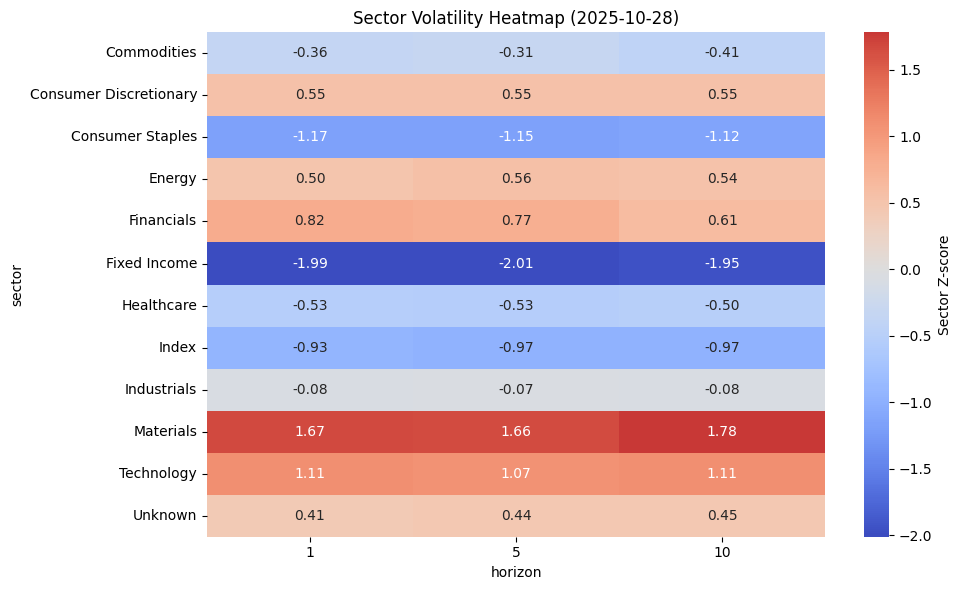

In [11]:
engine.plot_sector_heatmap()

> Interpretation
>
> * Colors correspond to sector-relative volatility z-scores.
> * Red → above-average volatility pressure (risk-off).
> * Blue → below-average volatility (risk-on or complacency).
> * Neutral → around mean, typical regime.
>
> This helps traders visualize which sectors are leading or lagging in volatility expansion.

## 7️⃣ Plot Top Sectors

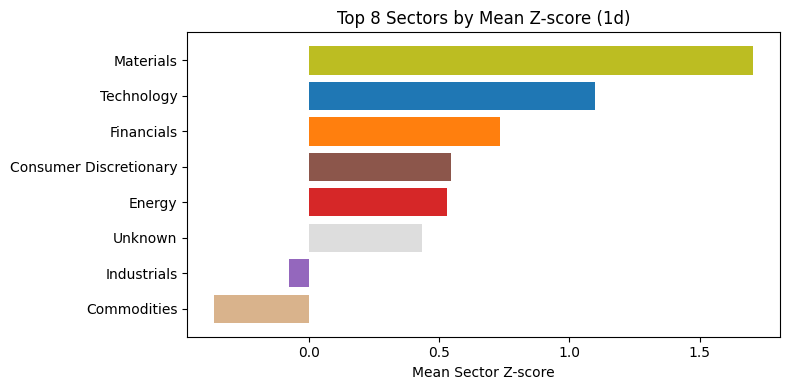

In [ ]:
horizon=1
engine.plot_top_sectors(horizon=horizon)

**Purpose:**
Ranks and visualizes the sectors with the strongest volatility pressure for a chosen horizon.

**What it shows**
- Bar chart of top-N sectors sorted by a selected metric:
  - `sector_mean`: raw average `forecast_vol` within the sector

## 8️⃣ Ticker Heatmap

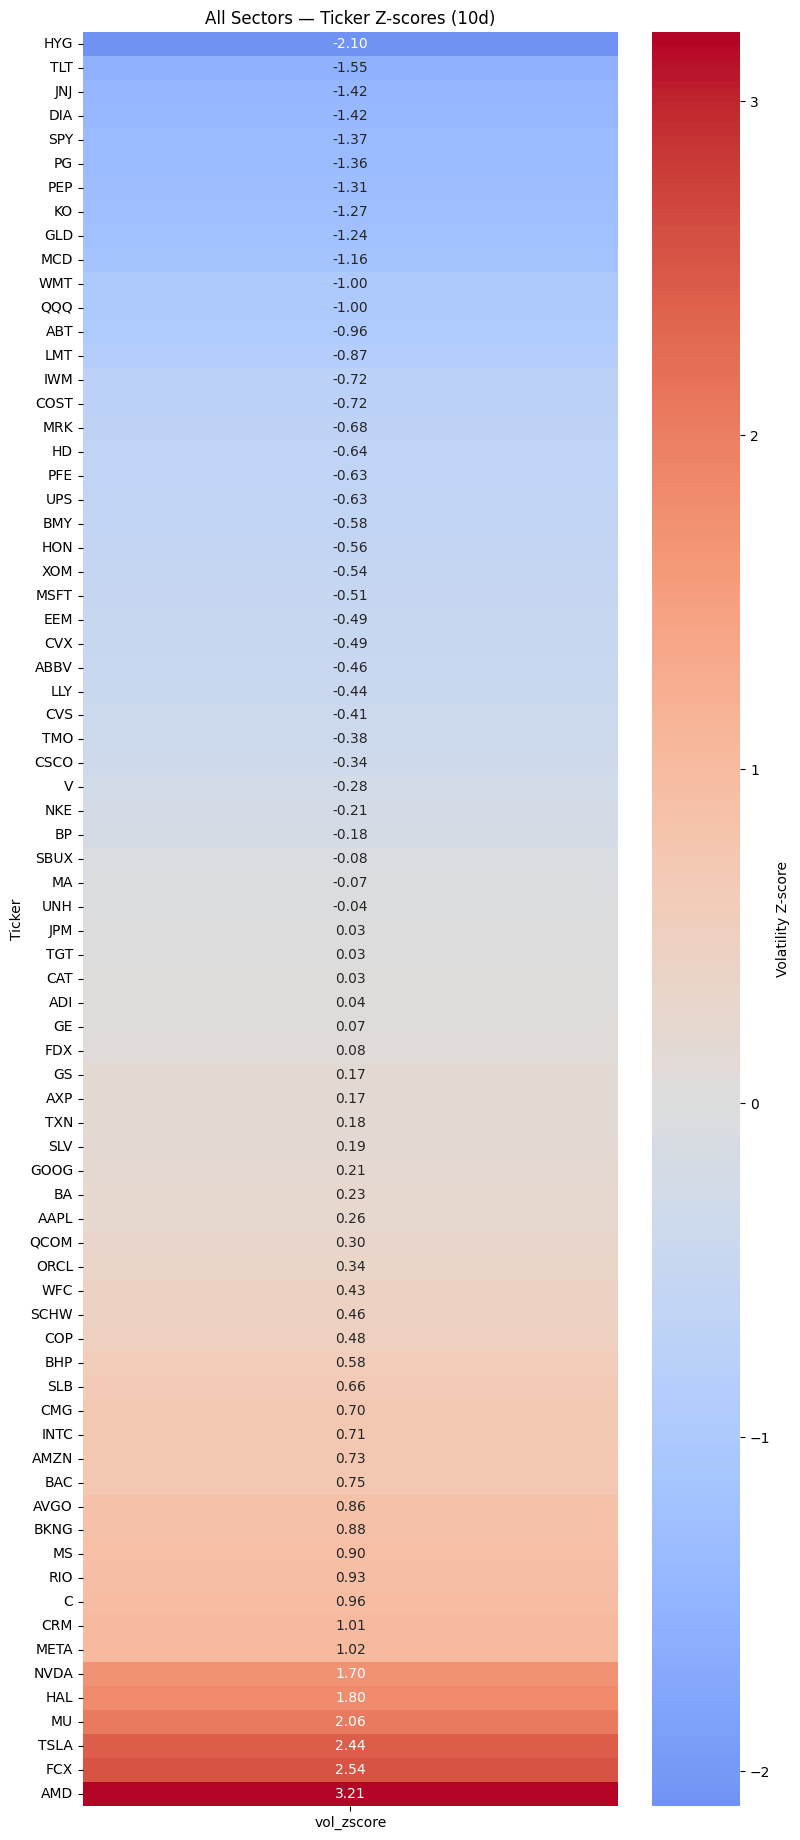

In [16]:
horizon=10
engine.plot_ticker_heatmap(horizon=horizon)

**Use Case:**
Visualizes **relative volatility elevation** across all tickers within the sample.
Darker reds indicate strong volatility build-up; blues indicate suppression or mean-reverting conditions.

## 9️⃣ Human-Readable Summary

In [21]:
for t in TICKERS[:5]:
    print(engine.ticker_summary(t))

SPY — 2025-10-28
  1d: fc=0.1789, today=0.1627 (+9.9%), z=-1.33, pos=long, regime=calm, sector=Index (z=-0.93, uni-rank=8%)
  5d: fc=0.1629, today=NaN (NaN), z=-1.38, pos=long, regime=calm, sector=Index (z=-0.97, uni-rank=8%)
  10d: fc=0.1420, today=NaN (NaN), z=-1.37, pos=long, regime=calm, sector=Index (z=-0.97, uni-rank=7%)
QQQ — 2025-10-28
  1d: fc=0.2281, today=0.2181 (+4.6%), z=-0.96, pos=neutral, regime=normal, sector=Index (z=-0.93, uni-rank=16%)
  5d: fc=0.2073, today=NaN (NaN), z=-1.00, pos=long, regime=calm, sector=Index (z=-0.97, uni-rank=15%)
  10d: fc=0.1802, today=NaN (NaN), z=-1.00, pos=neutral, regime=normal, sector=Index (z=-0.97, uni-rank=16%)
DIA — 2025-10-28
  1d: fc=0.1738, today=0.1325 (+31.1%), z=-1.37, pos=long, regime=calm, sector=Index (z=-0.93, uni-rank=7%)
  5d: fc=0.1582, today=NaN (NaN), z=-1.42, pos=long, regime=calm, sector=Index (z=-0.97, uni-rank=5%)
  10d: fc=0.1374, today=NaN (NaN), z=-1.42, pos=long, regime=calm, sector=Index (z=-0.97, uni-rank=5%)

This provides quick text-based insights, ideal for terminal monitoring or Slack/Telegram automation.

## 🔟 Trader Integration Ideas

* Integrate `SignalEngine` outputs into **risk dashboards** to monitor sector stress.
* Use **f/r ratios & z-scores** as triggers for **volatility overlays** (options hedging, VIX strategies).
* Combine with **cross-horizon consistency metrics** for **volatility term-structure analysis**.
* Automate **alerts** for extreme z-scores (> |2.5|) → potential volatility breakouts.

---

## **1️⃣1️⃣ Summary**

| Component         | Role                                           | Key Outputs                                          |
| ----------------- | ---------------------------------------------- | ---------------------------------------------------- |
| **Forecast**      | Generates multi-horizon volatility predictions | `pred_vol_1`, `pred_vol_5`, `pred_vol_10`            |
| **Analytics**     | Adds forecast-to-realized ratios & regimes     | `f/r_ratio`, `zscore`, `vol_regime`                  |
| **Signal Engine** | Aggregates & contextualizes forecasts          | `sector_heatmap`, `cross_horizon_corr`, `signals_df` |